# XAI Notebook

Contains some code for understanding the model's predictions.
PCA, attribution maps, ...

In [4]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb
import pandas as pd
from tqdm import tqdm
import ast
import warnings
import math
import matplotlib.pyplot as plt
import torch
import numpy as np
import gc
import random
from captum.attr import GradientShap
from typing import Sequence, Tuple, Optional
from torch.utils.data import DataLoader
from omegaconf import OmegaConf
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
from src.modeling.siglabv2.siglabv2 import SigLabV2
from src.modeling.datasets.siglab_dataset import SigLabDataset
from src.run import lead_sets
from src.utils import count_parameters, apply_preprocessors, plot_ecg
from src.data.load_ptbdata_new import PRECORDIAL_LEADS, ALL_LEADS

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading the model

In [2]:
project_path = "nateml-maastricht-university/bachelors-thesis"
#run_id = "83mabq4k"
#version = "v22"
run_id = "yh0by5uj"
version = "v30"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the torch model from wandb
api = wandb.Api()

run = api.run(f"{project_path}/{run_id}")
config = dict(run.config)

# Get the run name
run_name = run.name

artifact = api.artifact(f"{project_path}/{run_name}:{version}")
artifact_path = artifact.download()

# Convert config to omegaconf
cfg = OmegaConf.create(config)

# Load the model
checkpoint = torch.load(artifact_path + f"/{run_name}.pth", map_location=device)

# Cast the model to the correct type
model = SigLabV2(cfg.model).to(device)
model.load_state_dict(checkpoint)
model.eval()  # Put into evaluation mode

# Count number of parameters
print(f"Loaded model from wandb: {run_name}")
count_parameters(model)

wandb:   1 of 1 files downloaded.  


Loaded model from wandb: 63_siglabv2_inception_gru_2_2
+----------------------------------------+------------+
|                Modules                 | Parameters |
+----------------------------------------+------------+
|             encoder.alpha              |     1      |
| encoder.cnn_encoder.0.branch1.0.weight |     32     |
|  encoder.cnn_encoder.0.branch1.0.bias  |     32     |
| encoder.cnn_encoder.0.branch1.1.weight |     32     |
|  encoder.cnn_encoder.0.branch1.1.bias  |     32     |
| encoder.cnn_encoder.0.branch2.0.weight |     1      |
|  encoder.cnn_encoder.0.branch2.0.bias  |     1      |
| encoder.cnn_encoder.0.branch2.1.weight |     1      |
|  encoder.cnn_encoder.0.branch2.1.bias  |     1      |
| encoder.cnn_encoder.0.branch2.3.weight |    160     |
|  encoder.cnn_encoder.0.branch2.3.bias  |     32     |
| encoder.cnn_encoder.0.branch2.4.weight |     32     |
|  encoder.cnn_encoder.0.branch2.4.bias  |     32     |
| encoder.cnn_encoder.0.branch3.0.weight |     1 

(1365845, 307017)

In [16]:
model

SigLabV2(
  (encoder): CNNGRUEncoder(
    (activation): ReLU()
    (cnn_encoder): Sequential(
      (0): InceptionBlock(
        (activation): ReLU()
        (branch1): Sequential(
          (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (branch2): Sequential(
          (0): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
        (branch3): Sequential(
          (0): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv

## Data prep

In [3]:
dataset_path = Path("../../" + cfg.dataset.path)
if OmegaConf.select(cfg, "dataset.only_precordial"):
    dataset_path = dataset_path / "precordial"
else:
    dataset_path = dataset_path / "all"
dataset_path = dataset_path.resolve()

val_data = np.load(dataset_path / "val.npy")
test_data = np.load(dataset_path / "test.npy")

# Apply preprocessors
val_data = apply_preprocessors(val_data,
                               cfg.dataset.sampling_rate,
                               cfg.preprocessor_group.preprocessors)
test_data = apply_preprocessors(test_data,
                                cfg.dataset.sampling_rate,
                                cfg.preprocessor_group.preprocessors)
 
# Convert to torch tensor
val_data = torch.from_numpy(val_data).float().to(device)
val_data = val_data.permute(0, 2, 1)
print(val_data.shape)

test_data = torch.from_numpy(test_data).float().to(device)
test_data = test_data.permute(0, 2, 1)

# Create the dataset and dataloader
lead_filter = lead_sets[OmegaConf.select(cfg, "run.leads", default="precordial")]
dataset = SigLabDataset(test_data, filter_leads=lead_filter)
batch_size = 32
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False)

# I need to reorder val_data to match the order of the labels in the dataset
if OmegaConf.select(cfg, "dataset.only_precordial") or OmegaConf.select(cfg, "dataset.only_precordial") is None:
    val_data = val_data[:, [PRECORDIAL_LEADS.index(lead) for lead in lead_filter], :]
else:
    val_data = val_data[:, [ALL_LEADS.index(lead) for lead in lead_filter], :]

# Load metadata
meta_val = pd.read_csv(dataset_path / "meta_val.csv")
meta_test = pd.read_csv(dataset_path / "meta_test.csv")
meta = meta_val.copy()
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(lambda x: codes_above_threshold(x, THRESHOLD))

# Treat diagnostic superclass as lists
meta["diagnostic_superclass"] = meta["diagnostic_superclass"].apply(lambda x: ast.literal_eval(x))
# Now convert to a set
meta["diagnostic_superclass"] = meta["diagnostic_superclass"].apply(lambda x: set(x))

torch.Size([2183, 6, 1000])


## Inference

In [4]:
c = cfg.model.num_classes
logits = np.zeros((len(dataset), c, c))
init_logits = np.zeros((len(dataset), c, c))
targets = np.zeros((len(dataset), c))

for idx, (signals, lead_labels) in enumerate(dataloader):
    signals = signals.to(device)
    lead_labels = lead_labels.to(device)

    # Make predictions
    with torch.no_grad():
        these_logits = model(signals)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()
        targets[(idx * batch_size):(idx * batch_size + batch_size)] = lead_labels.cpu().numpy()

predictions = logits.argmax(axis=-1)
print(predictions.shape)

(2198, 6)


# SAB Attention Weights

In [5]:
# Hook onto the sab multihead attention module
attn_maps = {}
def save_sab(name):
    def _hook(module, input, output):
        attn_maps[name] = output[1].detach().cpu()

    return _hook

for i, sab in enumerate(model.attention_blocks):
    sab.mha.register_forward_hook(save_sab(f"attn_map_{i}")) # type: ignore

In [6]:
# Run a forwward pass
for idx, (signals, lead_labels) in enumerate(tqdm(dataloader)):
    signals = signals.to(device)
    lead_labels = lead_labels.to(device)

    # Make predictions
    with torch.no_grad():
        _ = model(signals)


100%|██████████| 69/69 [00:02<00:00, 30.60it/s]


In [8]:
# Unregister the hooks
for i, sab in enumerate(model.attention_blocks):
    sab.mha._forward_hooks.clear() # type: ignore

In [7]:
attn_maps['attn_map_1'].shape

torch.Size([22, 6, 6])

In [8]:
# Aggregate the attention maps
w = attn_maps['attn_map_0']

# Average heads
w_headavg = torch.mean(w, dim=0)

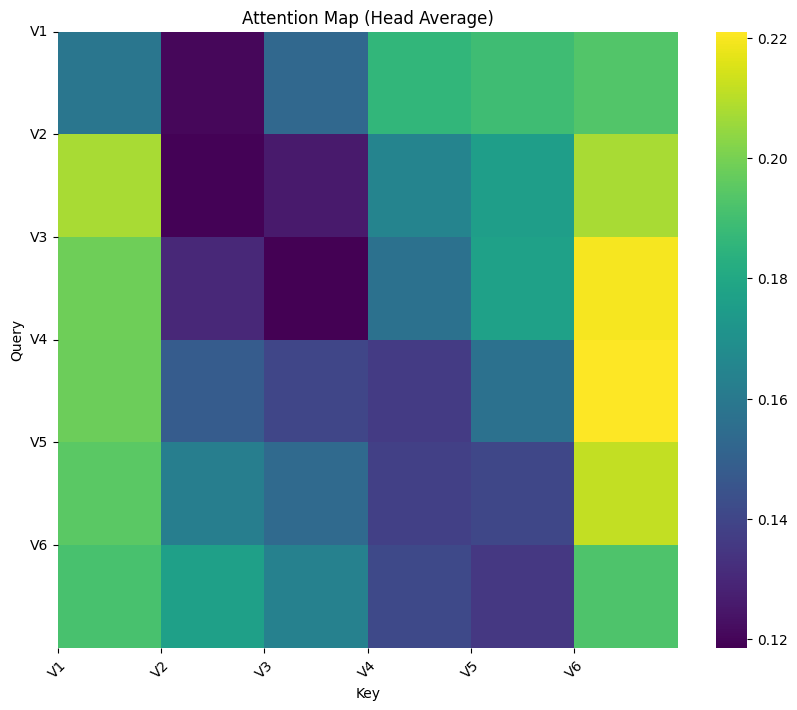

In [9]:
# Visualize the attention maps
def plot_attention_map(attention_map, title=""):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_map, cmap="viridis", cbar=True)
    plt.title(title)
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.xticks(ticks=np.arange(len(lead_filter)), labels=lead_filter, rotation=45)
    plt.yticks(ticks=np.arange(len(lead_filter)), labels=lead_filter, rotation=0)
    plt.show()


plot_attention_map(w_headavg, title="Attention Map (Head Average)")

# SHAP

In [10]:
lead = 0

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

class JointWrapper(torch.nn.Module):
    def __init__(self, model, signal_idx):
        super(JointWrapper, self).__init__()
        self.model = model
        self.signal_idx = signal_idx

    def forward(self, x):
        return self.model(x)[:, self.signal_idx]

class ModelWrapper(torch.nn.Module):
    def __init__(self, model, lead):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.lead = lead

    def forward(self, x):
        logits = self.model(x)
        return logits[:, self.lead, self.lead]  # Select the lead of interest

In [ ]:
model.train()
torch.cuda.empty_cache()
gc.collect()

batch_size = 4
batches = 20

ecg = val_data[0:batch_size * batches]

In [ ]:
attr = torch.zeros((6, batches * batch_size, 6, 1000), device=device)
# The first dimension is for the target lead, the second for the batch, the third for the input signal, and the last for the time dimension
for lead in range(6):
    gshap = GradientShap(ModelWrapper(model, lead), multiply_by_inputs=True)

    # Baselines are other samples in the dataset with the leard order shuffled
    baseline_ids = random.sample(range(len(val_data)), 100)
    baselines = torch.stack([test_data[i][random.sample(range(6), 6)] for i in baseline_ids], dim=0)
    for i in tqdm(range(batches)):
        this_ecg = ecg[i * batch_size:i * batch_size + batch_size]

        model.train()
        this_attr, delta = gshap.attribute(this_ecg, n_samples=30, stdevs=0.01, baselines=baselines, return_convergence_delta=True)
        attr[lead, i * batch_size:i * batch_size + batch_size, :, :] = this_attr

        torch.cuda.empty_cache()
        gc.collect()

print(attr.shape)

In [ ]:
# Save the attribution to disk
#np.save(f"resources/attributions_global.npy", attr.cpu().numpy())

In [120]:
# Load the attribution from disk
attr = np.load(f"resources/attributions_global.npy")
attr = torch.from_numpy(attr).float().to(device)

In [ ]:
# Free up memory
torch.cuda.empty_cache()
gc.collect()

0

# Segment ECGS

In [110]:
import neurokit2 as nk

def get_all_beats(ecg_signal, fs=100):

    # Get the R-peaks
    _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=fs)
    r_locs: list[int] = rpeaks["ECG_R_Peaks"]  # type: ignore

    pre = int(0.35 * fs)
    post = int(0.45 * fs)
     
    beats = []
    for r in r_locs:
        start, end = r - pre, r + post
        if start < 0 or end >= len(ecg_signal):
            continue
        beats.append((start, end, r))

    return beats

def slice_and_warp(x, attr, beats, target_len=1000):
    """
    x : (n_leads, n_samples)
    attr : (n_leads, n_samples)  the relevance map
    beats : list of tuples (start, end, r) from get_all_beats
    """

    X_beats, A_beats = [], []
    for s, e, _ in beats:
        seg_x = x[:, s:e]
        seg_a = attr[:, s:e]

        # Interpolate to target length
        seg_x = torch.nn.functional.interpolate(seg_x.unsqueeze(0), size=target_len, mode='linear', align_corners=False)[0]
        seg_a = torch.nn.functional.interpolate(seg_a.unsqueeze(0), size=target_len, mode='linear', align_corners=False)[0]

        X_beats.append(seg_x)
        A_beats.append(seg_a)
        
    return torch.stack(X_beats), torch.stack(A_beats)

relevance = attr.abs()
relevance.shape

torch.Size([6, 80, 6, 1000])

<Axes: title={'center': 'ECG signals array | sr=100 Hz'}, xlabel='Samples', ylabel='Leads'>

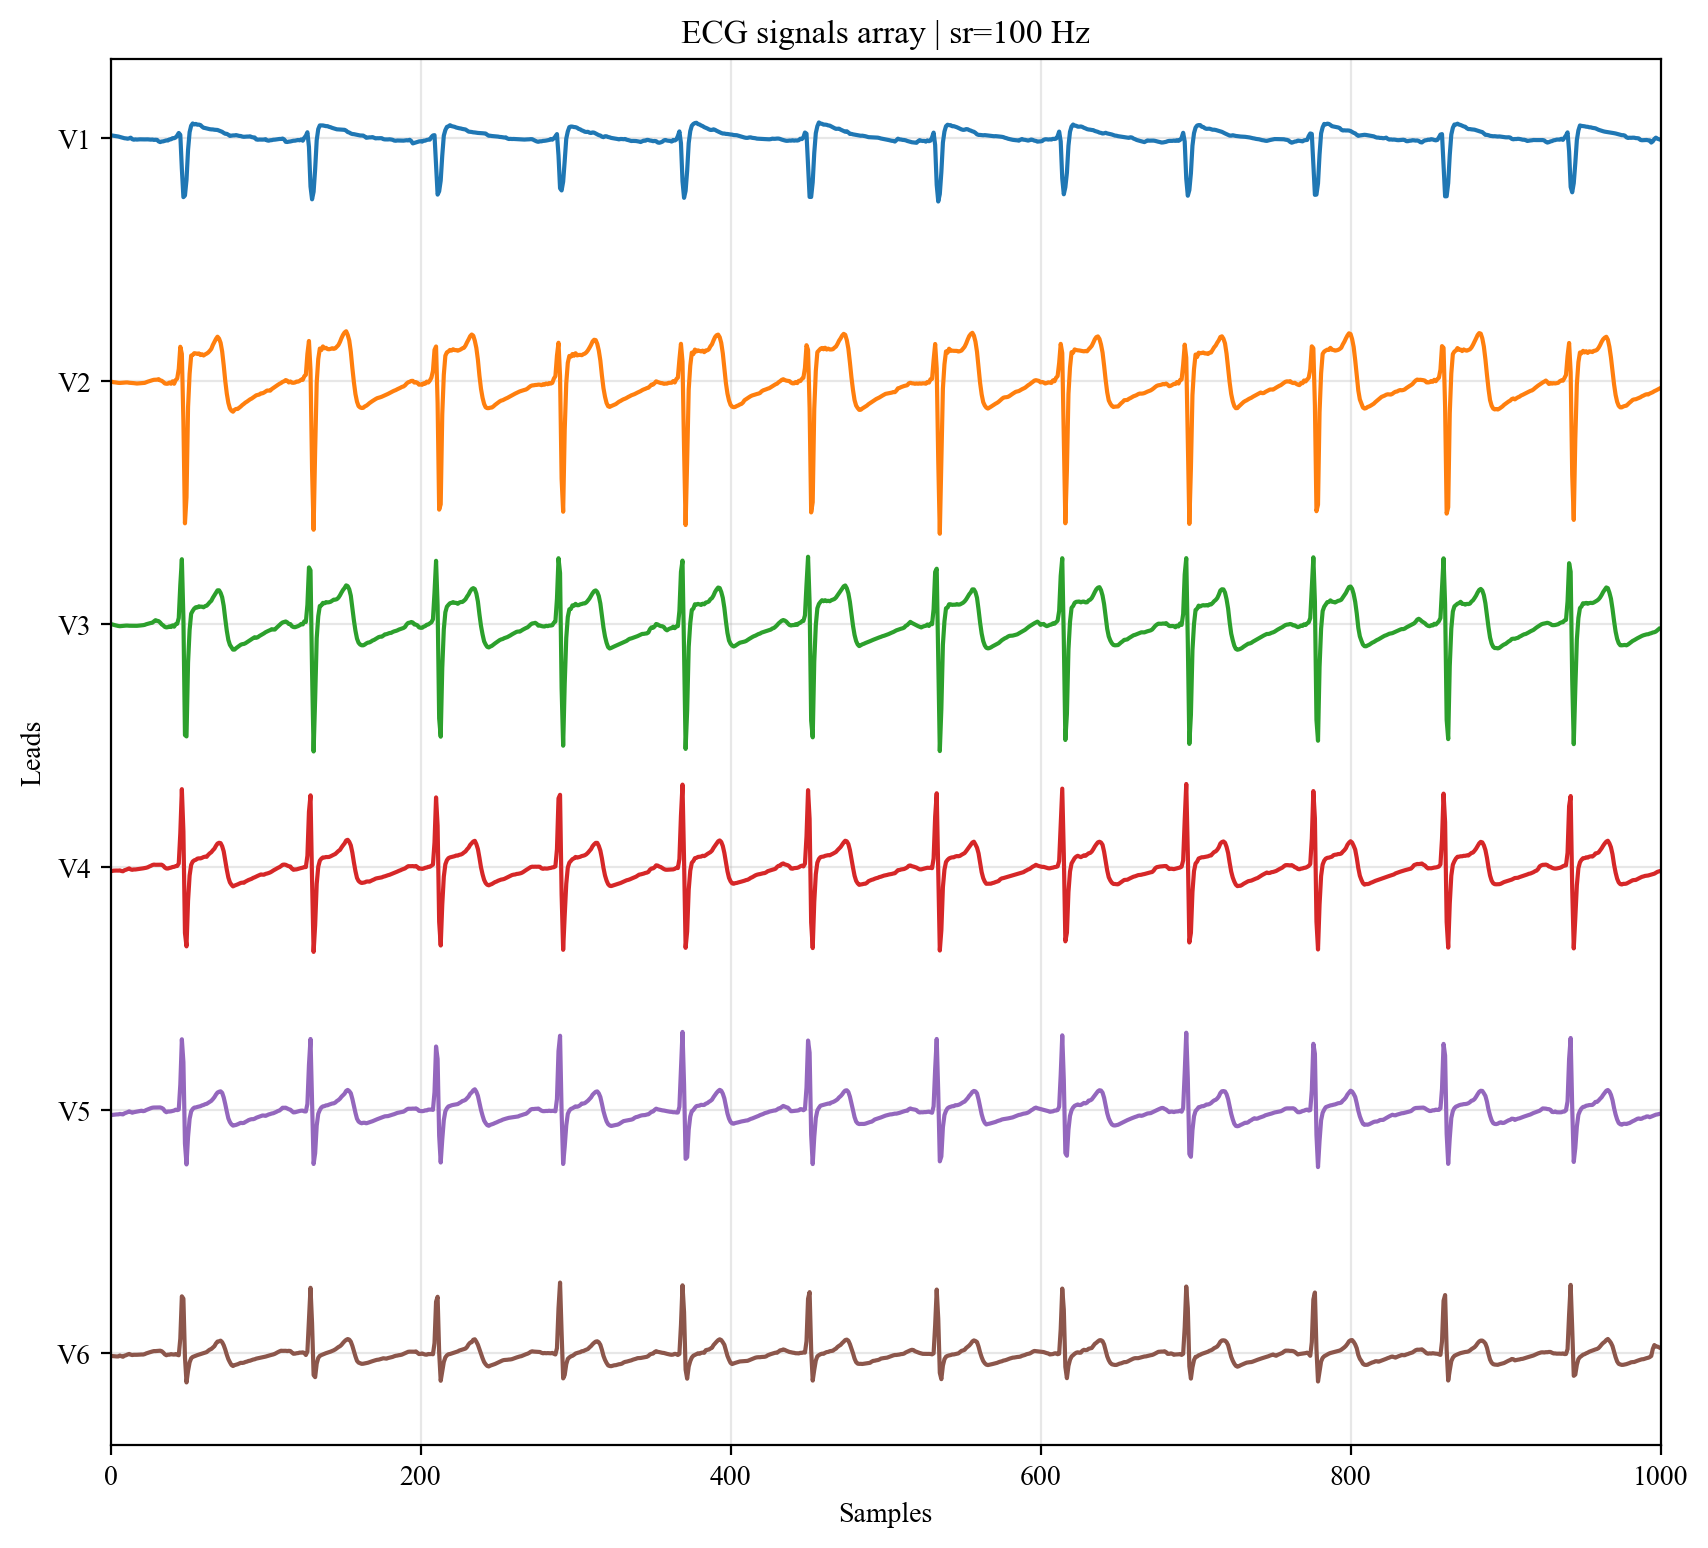

In [ ]:

plot_ecg(val_data[0].cpu().numpy(), width=10)

In [121]:
# Slice and stack the beats

all_x_beats, all_a_beats = [], []
for lead in range(6):
    lead_a_beats = []
    for i in range(ecg.shape[0]):
        x = ecg[i]
        a = relevance[lead, i]
        for j in range(x.shape[0]):
            beats = get_all_beats(x[j].cpu().numpy(), fs=100)
            if len(beats) == 0:
                continue  # skip this lead
            x_beats, a_beats = slice_and_warp(x, a, beats, target_len=1000)
            lead_a_beats.append(a_beats)
        all_x_beats.append(x_beats)
    all_a_beats.append(torch.cat(lead_a_beats, dim=0))

all_x_beats = torch.cat(all_x_beats, dim=0)
all_a_beats = torch.stack(all_a_beats, dim=0)
print(all_x_beats.shape)
print(all_a_beats.shape)

torch.Size([5658, 6, 1000])
torch.Size([6, 5608, 6, 1000])


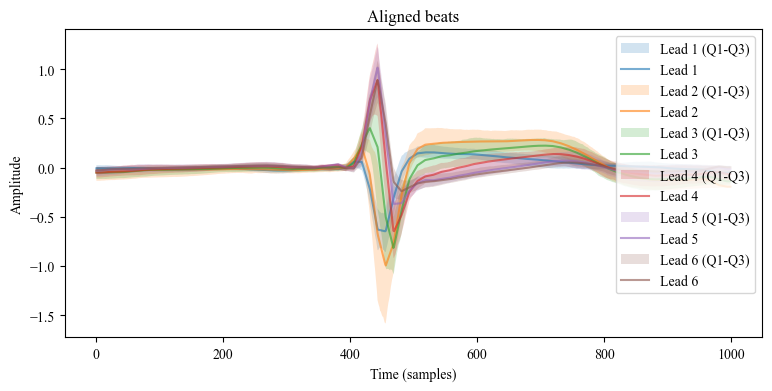

In [122]:
# Visualise aligned beats
all_x_beats = all_x_beats.cpu().numpy()
all_a_beats = all_a_beats.cpu().numpy()
fig, ax = plt.subplots(figsize=(9, 4))
for lead in range(all_x_beats.shape[1]):
    mean_beat = np.median(all_x_beats[:, lead, :], axis=0)
    q1_beat = np.quantile(all_x_beats[:, lead, :], 0.25, axis=0)
    q3_beat = np.quantile(all_x_beats[:, lead, :], 0.75, axis=0)
    ax.fill_between(np.arange(len(mean_beat)), q1_beat, q3_beat, alpha=0.2, label=f"Lead {lead+1} (Q1-Q3)")
    mean_beat = np.mean(all_x_beats, axis=0)[lead]
    ax.plot(mean_beat, label=f"Lead {lead+1}", alpha=0.6)

ax.set_title("Aligned beats")
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Amplitude")
ax.legend()
plt.show()

In [ ]:
def plot_attribution_map(
    relevance: torch.Tensor,
    ecg: torch.Tensor,
    title: str = "",
    time_window: Optional[Tuple[int, int]] = None,
    lead_names: Optional[Sequence[str]] = None,
    figsize: Tuple[int, int] = (6, 2.5),  # size of ONE cell
    line_alpha: float = 0.9,
    cmap: str = "Reds",
    show_hist: bool = False,
    predictions: Optional[torch.Tensor] = None,
    linestyle: str = "--"
):
    """Overlay a normalised attribution (relevance) heat‑map on ECG traces.

    Now arranges subplots in a **3×3 grid** (up to 9 cells).  If fewer than
    nine leads are supplied the extra axes are hidden so the layout stays
    rectangular.
    """

    # Change font
    plt.rcParams.update({
        "font.family": "Times New Roman"
    })

    # ------------------------------------------------------------------
    # shape handling ----------------------------------------------------
    # ------------------------------------------------------------------
    if ecg.ndim == 3:  # (batch, lead, T) → (lead, T)
        ecg = ecg.squeeze(0)
    #if relevance.ndim == 3:
        #relevance = relevance.squeeze(0)

    n_leads, T = ecg.shape

    # ------------------------------------------------------------------
    # prepare colours ---------------------------------------------------
    # ------------------------------------------------------------------
    dark_blue = "#001C3D"
    um_cmap = LinearSegmentedColormap.from_list(
        "um_blues", ["#ffffff", "#d6eeff", "#0070A3", dark_blue], N=256
    )
    cmap = um_cmap if cmap == "UM" else cmap

    # ------------------------------------------------------------------
    # window slicing ----------------------------------------------------
    # ------------------------------------------------------------------
    if time_window is None:
        time_window = (0, T)
    sl = slice(*time_window)

    ecg_w       = ecg[:, sl].cpu()
    relevance_w = relevance[:, :, sl].cpu()

    relevance_norm = relevance_w.clone()
    # Normalise over the whole structure
    # relevance_norm = (relevance_norm - relevance_norm.min()) / (relevance_norm.max() - relevance_norm.min() + 1e-9)

    # normalise relevance per target lead
    for ld in range(n_leads):
        rel = relevance_norm[ ld]
        relevance_norm[ld] = (rel - rel.min()) / (rel.max() - rel.min() + 1e-9)

    # ------------------------------------------------------------------
    # figure & axes -----------------------------------------------------
    # ------------------------------------------------------------------
    n_cols = 2
    n_rows = math.ceil(n_leads / n_cols)

    fig_w = figsize[0] * n_cols
    fig_h = figsize[1] * n_rows
    fig, axes_grid = plt.subplots(
        n_rows,
        n_cols,
        sharex=True,
        figsize=(fig_w, fig_h),
        constrained_layout=True,
        dpi=400,
    )
    axes = axes_grid.flatten()

    x_vals = np.arange(sl.start, sl.stop)
    last_im = None

    for idx in range(len(axes)):
        ax = axes[idx]

        # hide unused axes (e.g. 7–9 when n_leads =6)
        if idx >= n_leads:
            ax.axis("off")
            continue

        # ------------------------------------------------------------------
        # per‑lead plotting ----------------------------------------------
        # ------------------------------------------------------------------
        lead_lbl = (
            lead_names[idx] if (lead_names and idx < len(lead_names))
            else f"{lead_filter[idx]}"
        )

        if predictions is not None:
            lead_lbl += f" (pred: {lead_filter[predictions[idx]]})"

        # ECG waveform
        ax.plot(
            x_vals,
            ecg_w[idx].numpy(),
            lw=1.2,
            alpha=line_alpha,
            color=dark_blue,
            linestyle=linestyle,
        )

        # remove ticks for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])

        # fixed y‑limits (same for all cells so colour rows align visually)
        ax.set_ylim(ecg_w.min().item(), ecg_w.max().item())

        # heat‑map rows (one per *input* lead)
        im_height = (ecg_w.max().item() - ecg_w.min().item()) / n_leads
        for lead in range(n_leads):
            last_im = ax.imshow(
                relevance_norm[lead, idx].unsqueeze(0),
                aspect="auto",
                interpolation="nearest",
                origin="lower",
                extent=[sl.start, sl.stop - 1,
                        (n_leads - lead - 1) * im_height + ecg_w.min().item(),
                        (n_leads - lead) * im_height + ecg_w.min().item()],
                cmap=cmap,
                vmin=0,
                vmax=1,
                alpha=0.9,
            )
            # Add border to the im
            ax.add_patch(
                plt.Rectangle(
                    (sl.start, (6-lead-1) * im_height + ecg_w.min().item()),
                    sl.stop - 1 - sl.start,
                    im_height,
                    linewidth=0.5,
                    edgecolor='black',
                    facecolor='none',
                    linestyle='--',
                    alpha=0.5
                )
            )
            # label the im with the lead name
            if lead == 0 and idx == 0:
                #label = f"Relevance of V1 when labelling {lead_filter[lead]}"
                label = lead_filter[lead]
                font_size = 14
            elif lead == 1 and idx == 0:
                #label = f"... of V1 when labelling {lead_filter[lead]}"
                label = lead_filter[lead]
                font_size = 14
            else:
                label = lead_filter[lead]
                font_size = 14
            ax.text(
                sl.stop - 1 - 15,  # Shifted to the right
                (6-lead-1) * im_height + ecg_w.min().item() + im_height / 2,
                label,
                ha="right",
                va="center",
                fontsize=font_size,
                color='black',
            )

        # title inside each cell (avoids cramped y‑labels in grid)
        if lead_lbl[:2] == lead_lbl[-3:-1] or predictions is None:
            # Set colour to blue
            colour = 'black'
        else:
            colour = 'red'
        ax.set_title(f"{lead_lbl}", loc="left", fontsize=18, pad=2, color=colour)

        # optional histogram overlay
        if show_hist:
            ax2 = ax.twinx()
            ax2.fill_between(x_vals, relevance_norm[idx].numpy(), color="0.6", alpha=0.4)
            ax2.set_ylim(0, 1)
            ax2.set_yticks([])
            ax2.grid(False)

    # ------------------------------------------------------------------
    # final touches -----------------------------------------------------
    # ------------------------------------------------------------------
    fig.suptitle(title, fontsize=24, y=1.05)

    # single colour‑bar
    if last_im is not None:
        cbar = fig.colorbar(last_im, ax=axes[:n_leads], fraction=0.015, pad=0.015)
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label("Relevance", rotation=270, labelpad=16, fontsize=18)

    plt.show()

    return fig, axes


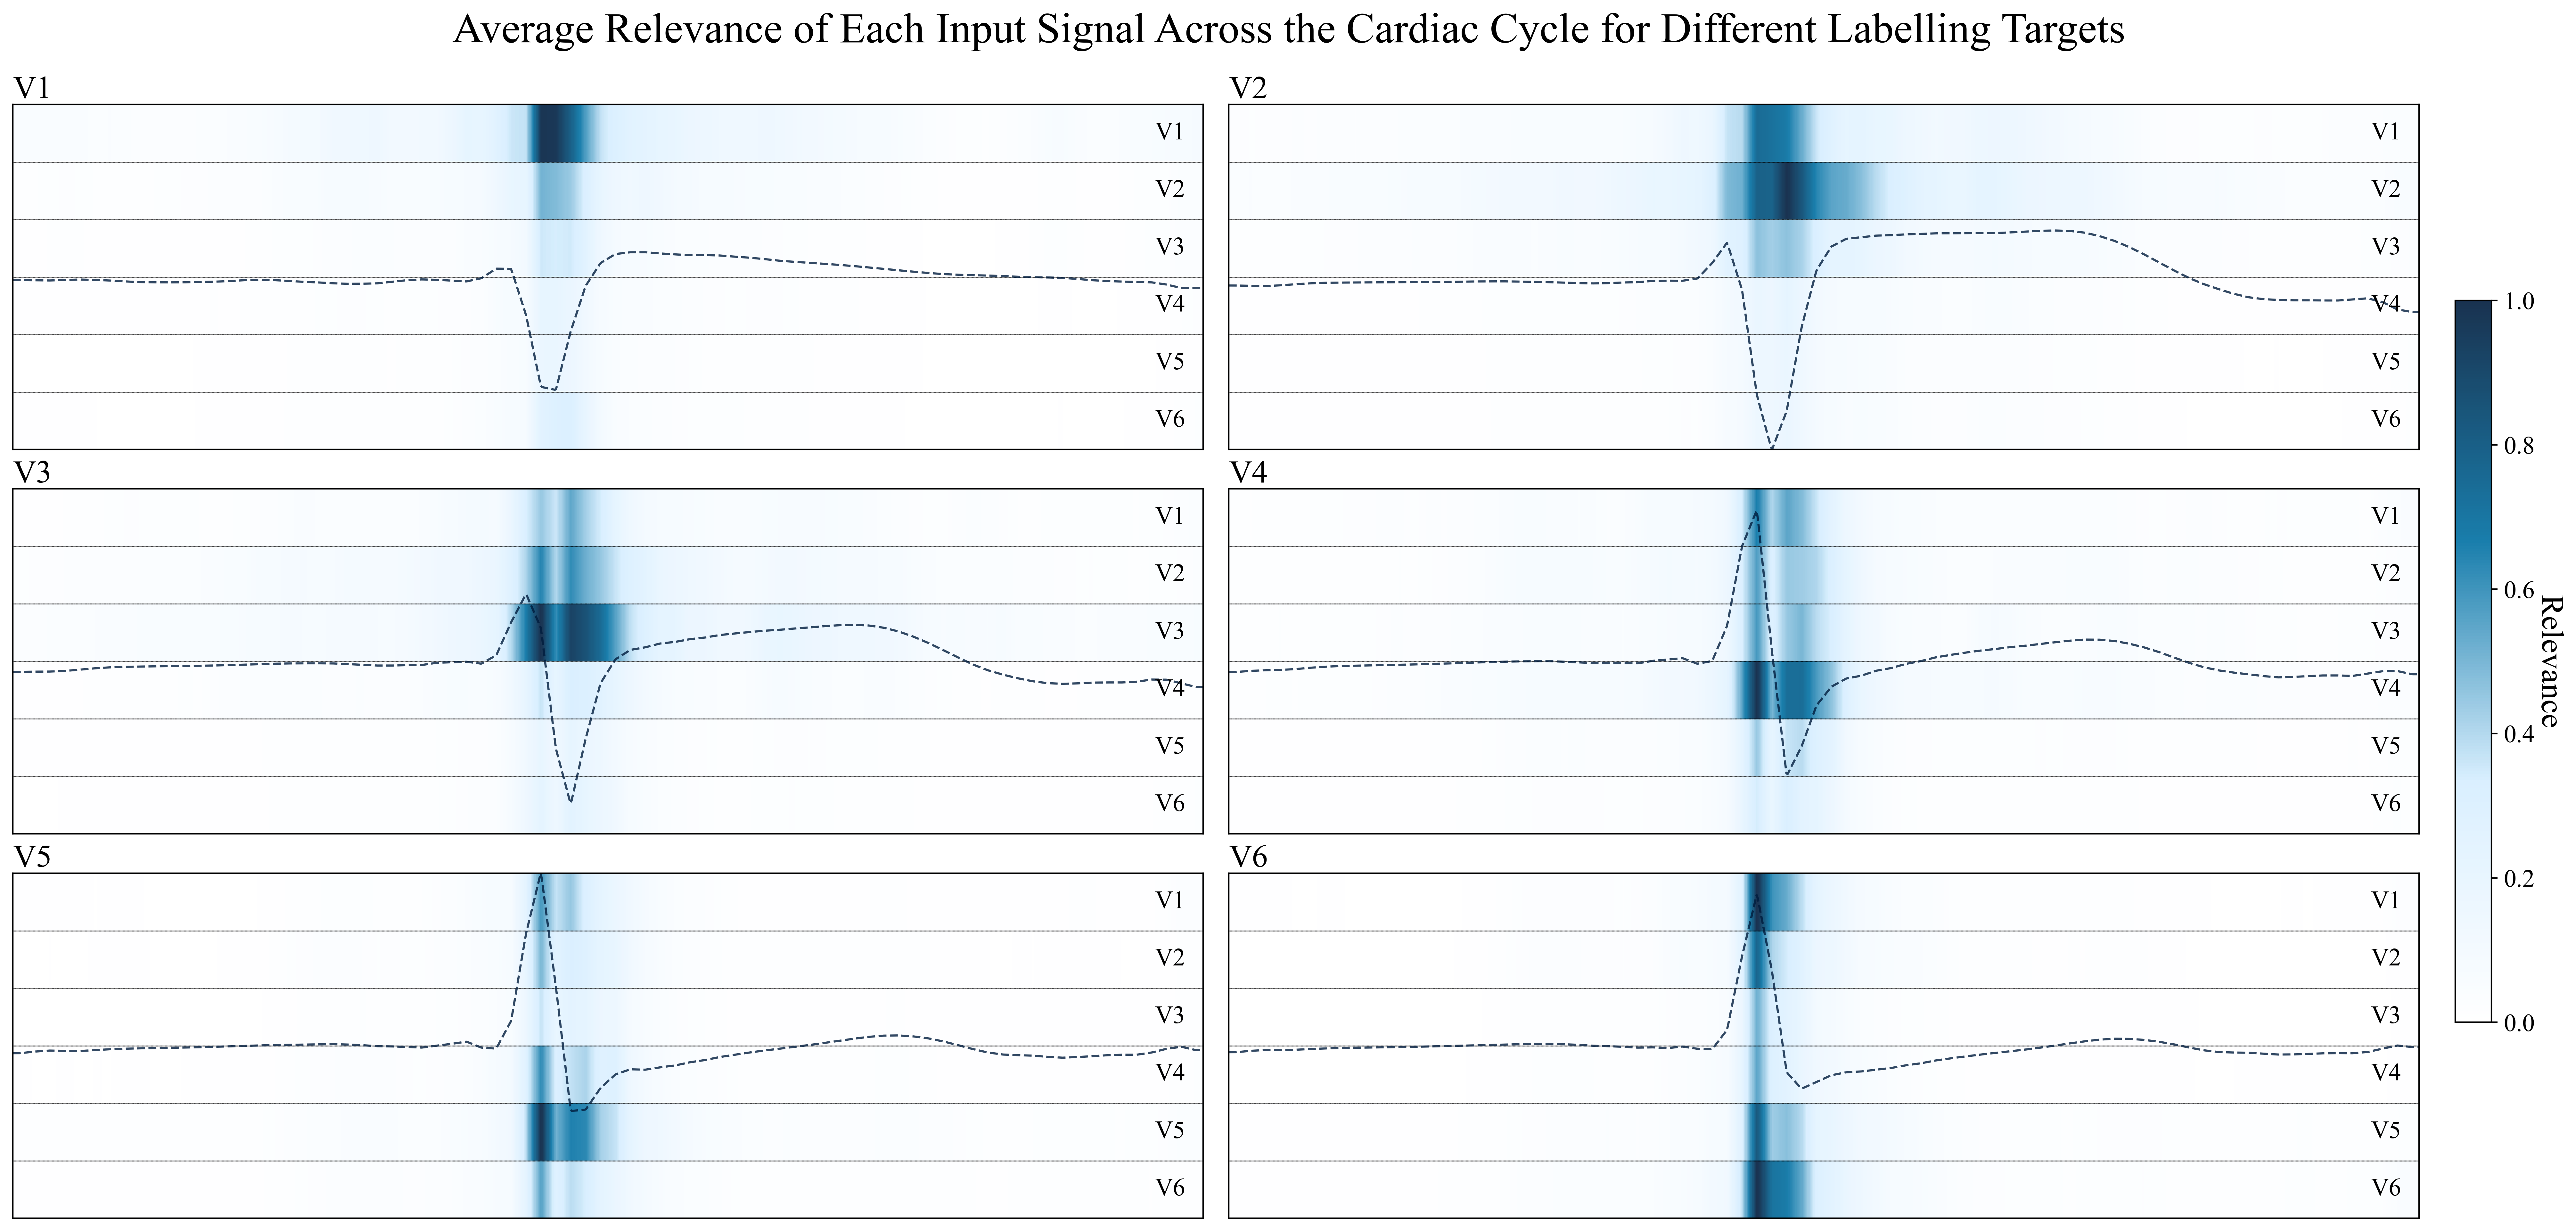

In [130]:
# Calculate the mean relevance
# Convert to tensor
if not isinstance(all_x_beats, torch.Tensor):
    all_x_beats = torch.from_numpy(all_x_beats).float()
if not isinstance(all_a_beats, torch.Tensor):
    all_a_beats = torch.from_numpy(all_a_beats).float()

mean_relevance = torch.mean(all_a_beats, dim=1)
mean_ecg = torch.mean(all_x_beats, dim=0)

cmap = LinearSegmentedColormap.from_list(
    "um_blues", ['#ffffff', '#d6eeff', '#0070A3', "#001C3D"], N=256
)
cmap = 'UM'
fig, axes = plot_attribution_map(mean_relevance, mean_ecg, title="Average Relevance of Each Input Signal Across the Cardiac Cycle for Different Labelling Targets", figsize=(10, 3), show_hist=False, line_alpha=0.8, cmap=cmap)
# Save the figure
#fig.savefig("relevance_map_global.png", dpi=500, bbox_inches='tight')
#fig.savefig("ShapGradrelevance_map_v1.pdf", dpi=500, bbox_inches='tight')

# Specific cases

The following is pretty messy and I don't even know if it works anymore.

In [15]:
# Get the indices of the samples where V6 is labelled as V2
v6_as_v2 = np.where(predictions[:, 5] == 1)[0]
print(f"Number of samples where V6 is labelled as V2: {len(v6_as_v2)}")
print(predictions[v6_as_v2])

Number of samples where V6 is labelled as V2: 2
[[0 4 3 2 1 1]
 [0 2 2 4 4 1]]


In [156]:
norm_samples = np.where(meta_test['diagnostic_superclass'].apply(lambda x: 'NORM' in x))[0]
mi_samples = np.where(meta_test['diagnostic_superclass'].apply(lambda x: 'MI' in x))[0]
cd_samples = np.where(meta_test['diagnostic_superclass'].apply(lambda x: 'CD' in x))[0]
hyp_samples = np.where(meta_test['diagnostic_superclass'].apply(lambda x: 'HYP' in x))[0]
print(f"Number of samples with NORM: {len(norm_samples)}")

Number of samples with NORM: 963


In [21]:
type(ecg)

torch.Tensor

atrial fibrillation with rapid ventricular response. incomplete right bundle branch block. st segments are depressed in i, v2-6. non-specific but consistent with myocardial ischaemia.
Unnamed: 0                                                                    556
ecg_id                                                                        569
patient_id                                                                 2936.0
age                                                                         300.0
sex                                                                             1
height                                                                      163.0
weight                                                                       63.0
nurse                                                                         4.0
site                                                                          1.0
device                                                                 AT-6 C 

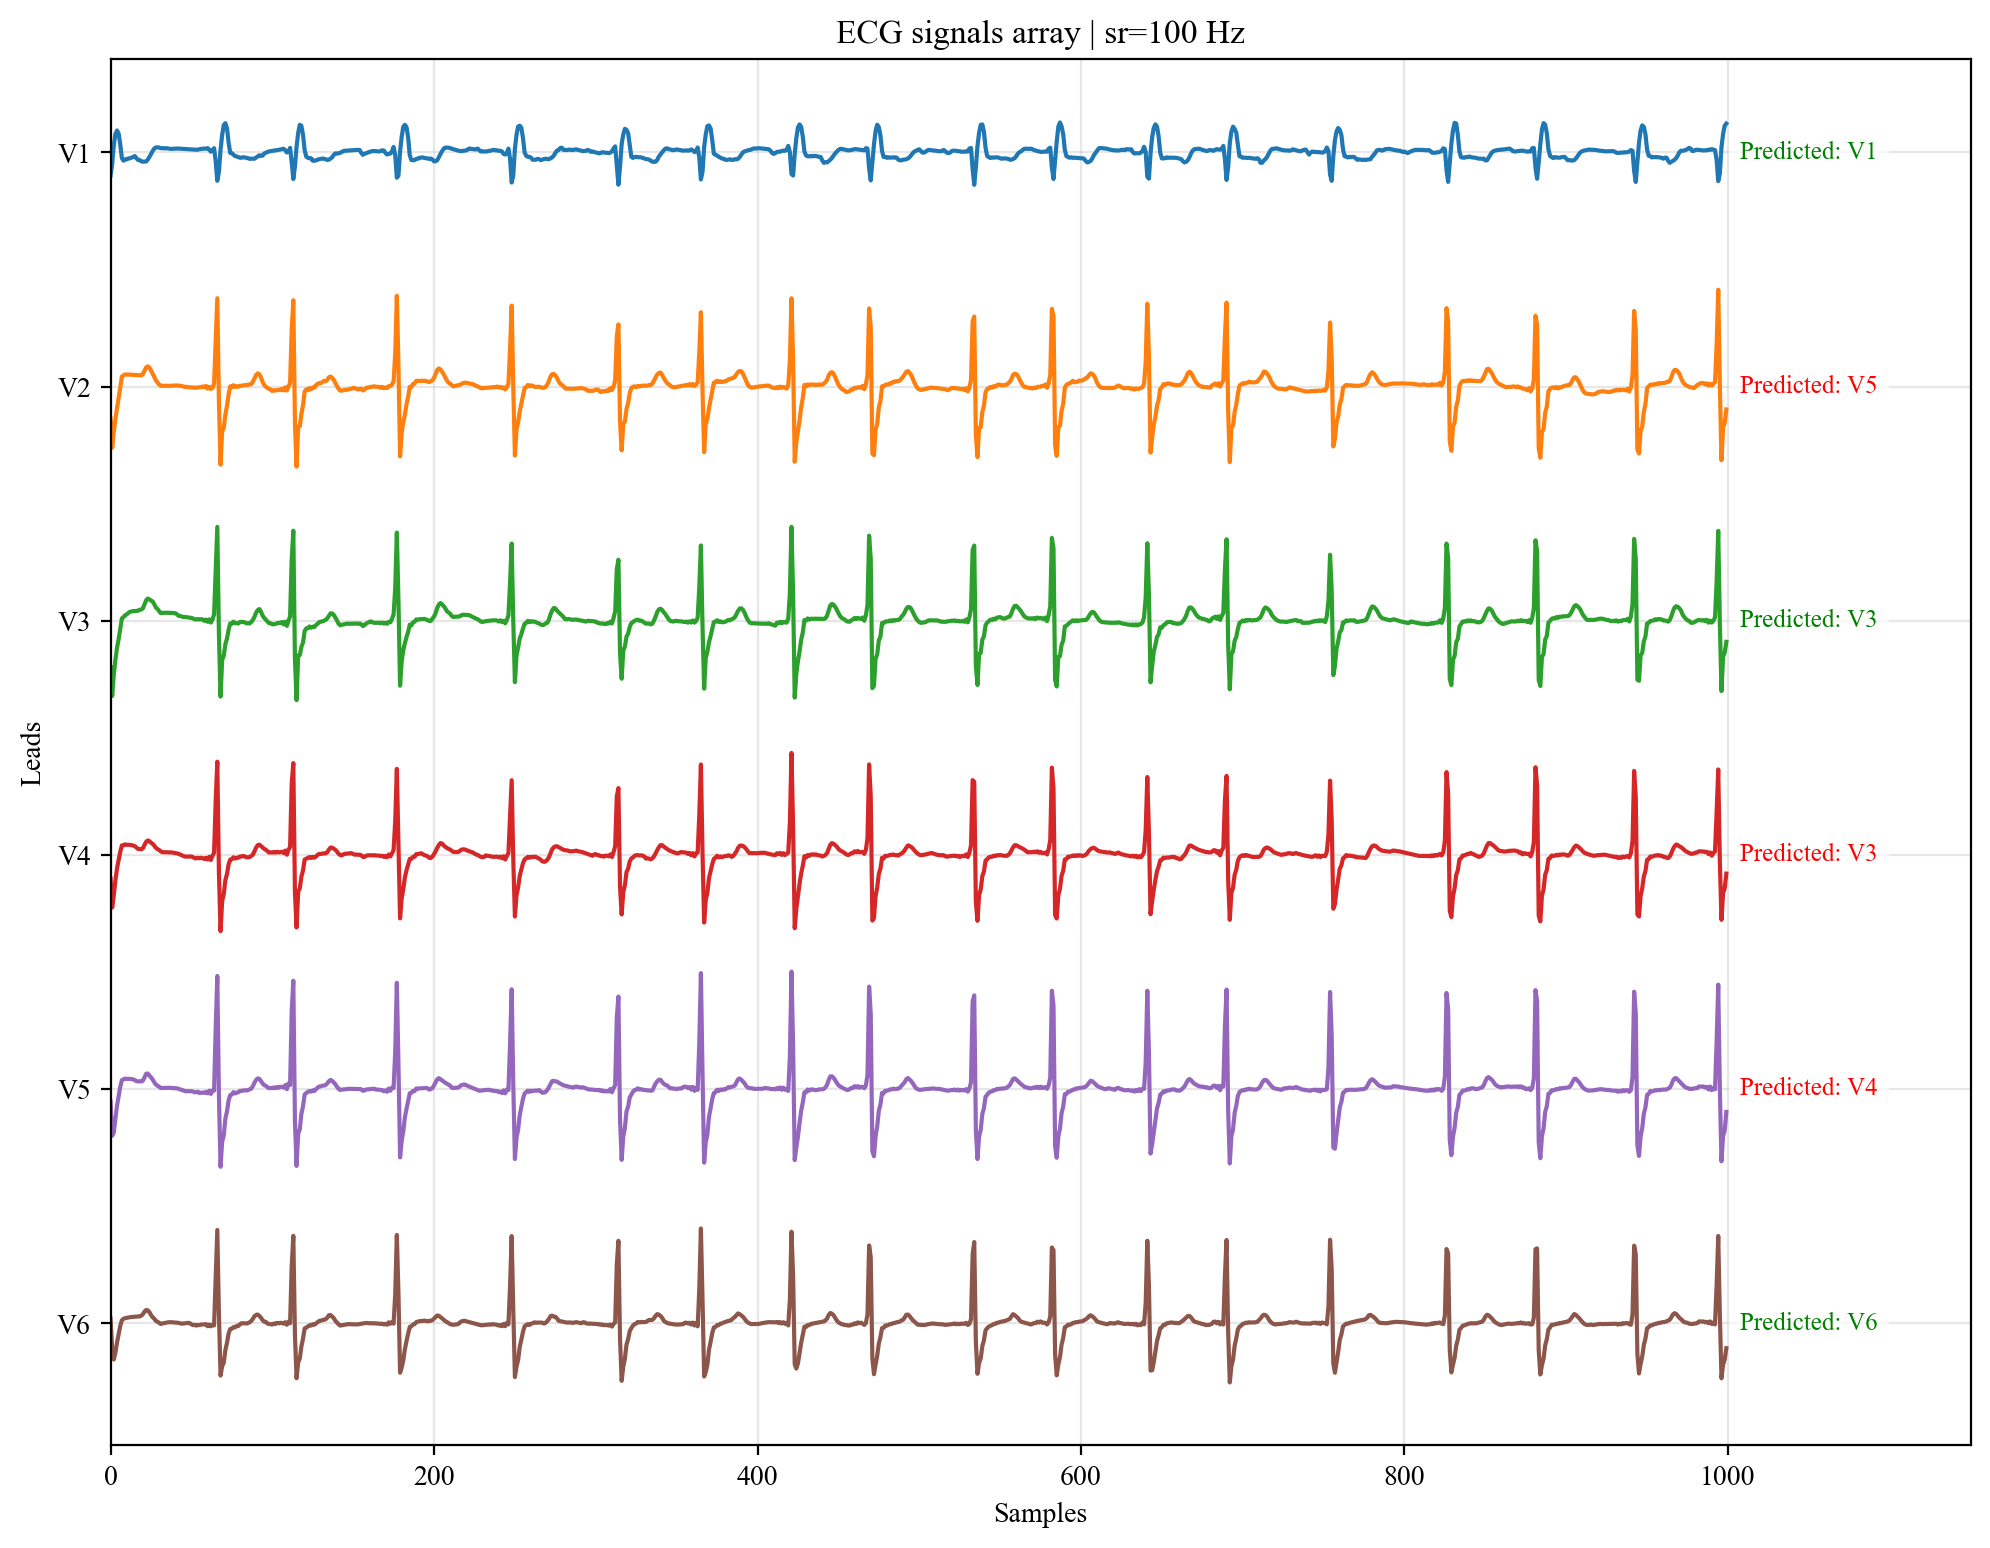

In [ ]:
#idx = v6_as_v2[1]
#idx = mi_samples[5]
#idx = norm_samples[0]
idx = cd_samples[13]
ecg_id = meta_test.iloc[idx]["ecg_id"]
ecg = test_data[idx]
print(meta_test.iloc[idx].report)
print(meta_test.iloc[idx])
ecg = ecg.unsqueeze(0)
# Inference
logits = model(ecg.to(device))
# Convert logits to probabilities
probs = torch.sigmoid(logits).cpu().detach().numpy()
probs_for_preds = []
# Print the probabilities
for i in probs[0]:
    probs_for_preds.append(float(f"{np.max(i):.4f}"))

preds = logits.argmax(axis=-1)
str_predictions = [lead_filter[p] for p in preds[0]]
plot_ecg(ecg.squeeze(0).cpu().numpy(), predictions=str_predictions, width=12)

print(f"predictions: {str_predictions}")
print(probs_for_preds)
print(meta_test.iloc[idx].report)

In [215]:
print(meta_test.iloc[idx].report)

sinusrytm svÅrbestÄmmbar el-axel lÅga qrs amplituder i extremitetsavledningarna hÖgersidigt skÄnkelblock


In [ ]:

# Get the attributions
attrs = torch.zeros((6, 1, 6, 1000), device=device)
for lead in range(6):
    gshap = GradientShap(ModelWrapper(model, lead), multiply_by_inputs=True)
    ecg = ecg.to(device)
    baseline_ids = random.sample(range(len(test_data)), 100)
    baselines = torch.stack([test_data[i][random.sample(range(6), 6)] for i in baseline_ids], dim=0)
    model.train()
    attrs[lead], delta = gshap.attribute(ecg, n_samples=100, stdevs=0.01, baselines=baselines, return_convergence_delta=True)
    print(f"Delta mean: {delta.mean().item()}, Delta std: {delta.std().item()}")

    torch.cuda.empty_cache()
    gc.collect()

attrs = attrs.squeeze(1)
attrs.shape

Delta mean: 5.093391418457031, Delta std: 65.76868438720703
Delta mean: 1.6597355604171753, Delta std: 44.622901916503906
Delta mean: -5.61590051651001, Delta std: 17.917133331298828
Delta mean: -3.43556547164917, Delta std: 31.641454696655273
Delta mean: 1.5634475946426392, Delta std: 54.351287841796875
Delta mean: 0.5541419982910156, Delta std: 32.94318771362305


torch.Size([6, 6, 1000])

In [82]:
attrs.shape, ecg.squeeze(0).shape

(torch.Size([6, 6, 1000]), torch.Size([6, 1000]))

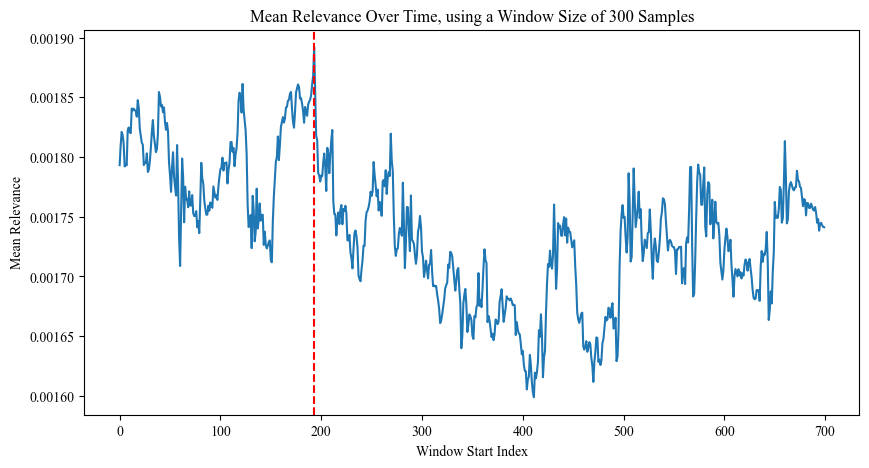

Best start index: 193, max relevance: 0.0018919841386377811


In [217]:
window_size = 300
# Find time window which includes the highest relevances
max_relevance = 0
relevances = []
for i in range(1000 - window_size):
    window = attrs[:, :, i:i + window_size]
    mean_relevance = window.mean(dim=-1).mean(dim=-1).mean(dim=-1)
    if mean_relevance.max() > max_relevance:
        max_relevance = mean_relevance.max()
        best_start = i
    relevances.append(mean_relevance.cpu().item())

# Plot the relevances
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1000 - window_size), np.array(relevances))
plt.axvline(best_start, color='red', linestyle='--', label='Best Start')
plt.title(f"Mean Relevance Over Time, using a Window Size of {window_size} Samples")
plt.xlabel("Window Start Index")
plt.ylabel("Mean Relevance")
plt.show()

# Print the best start index
print(f"Best start index: {best_start}, max relevance: {max_relevance.item()}")

In [186]:
print(predictions[idx])

[0 1 2 2 4 4]


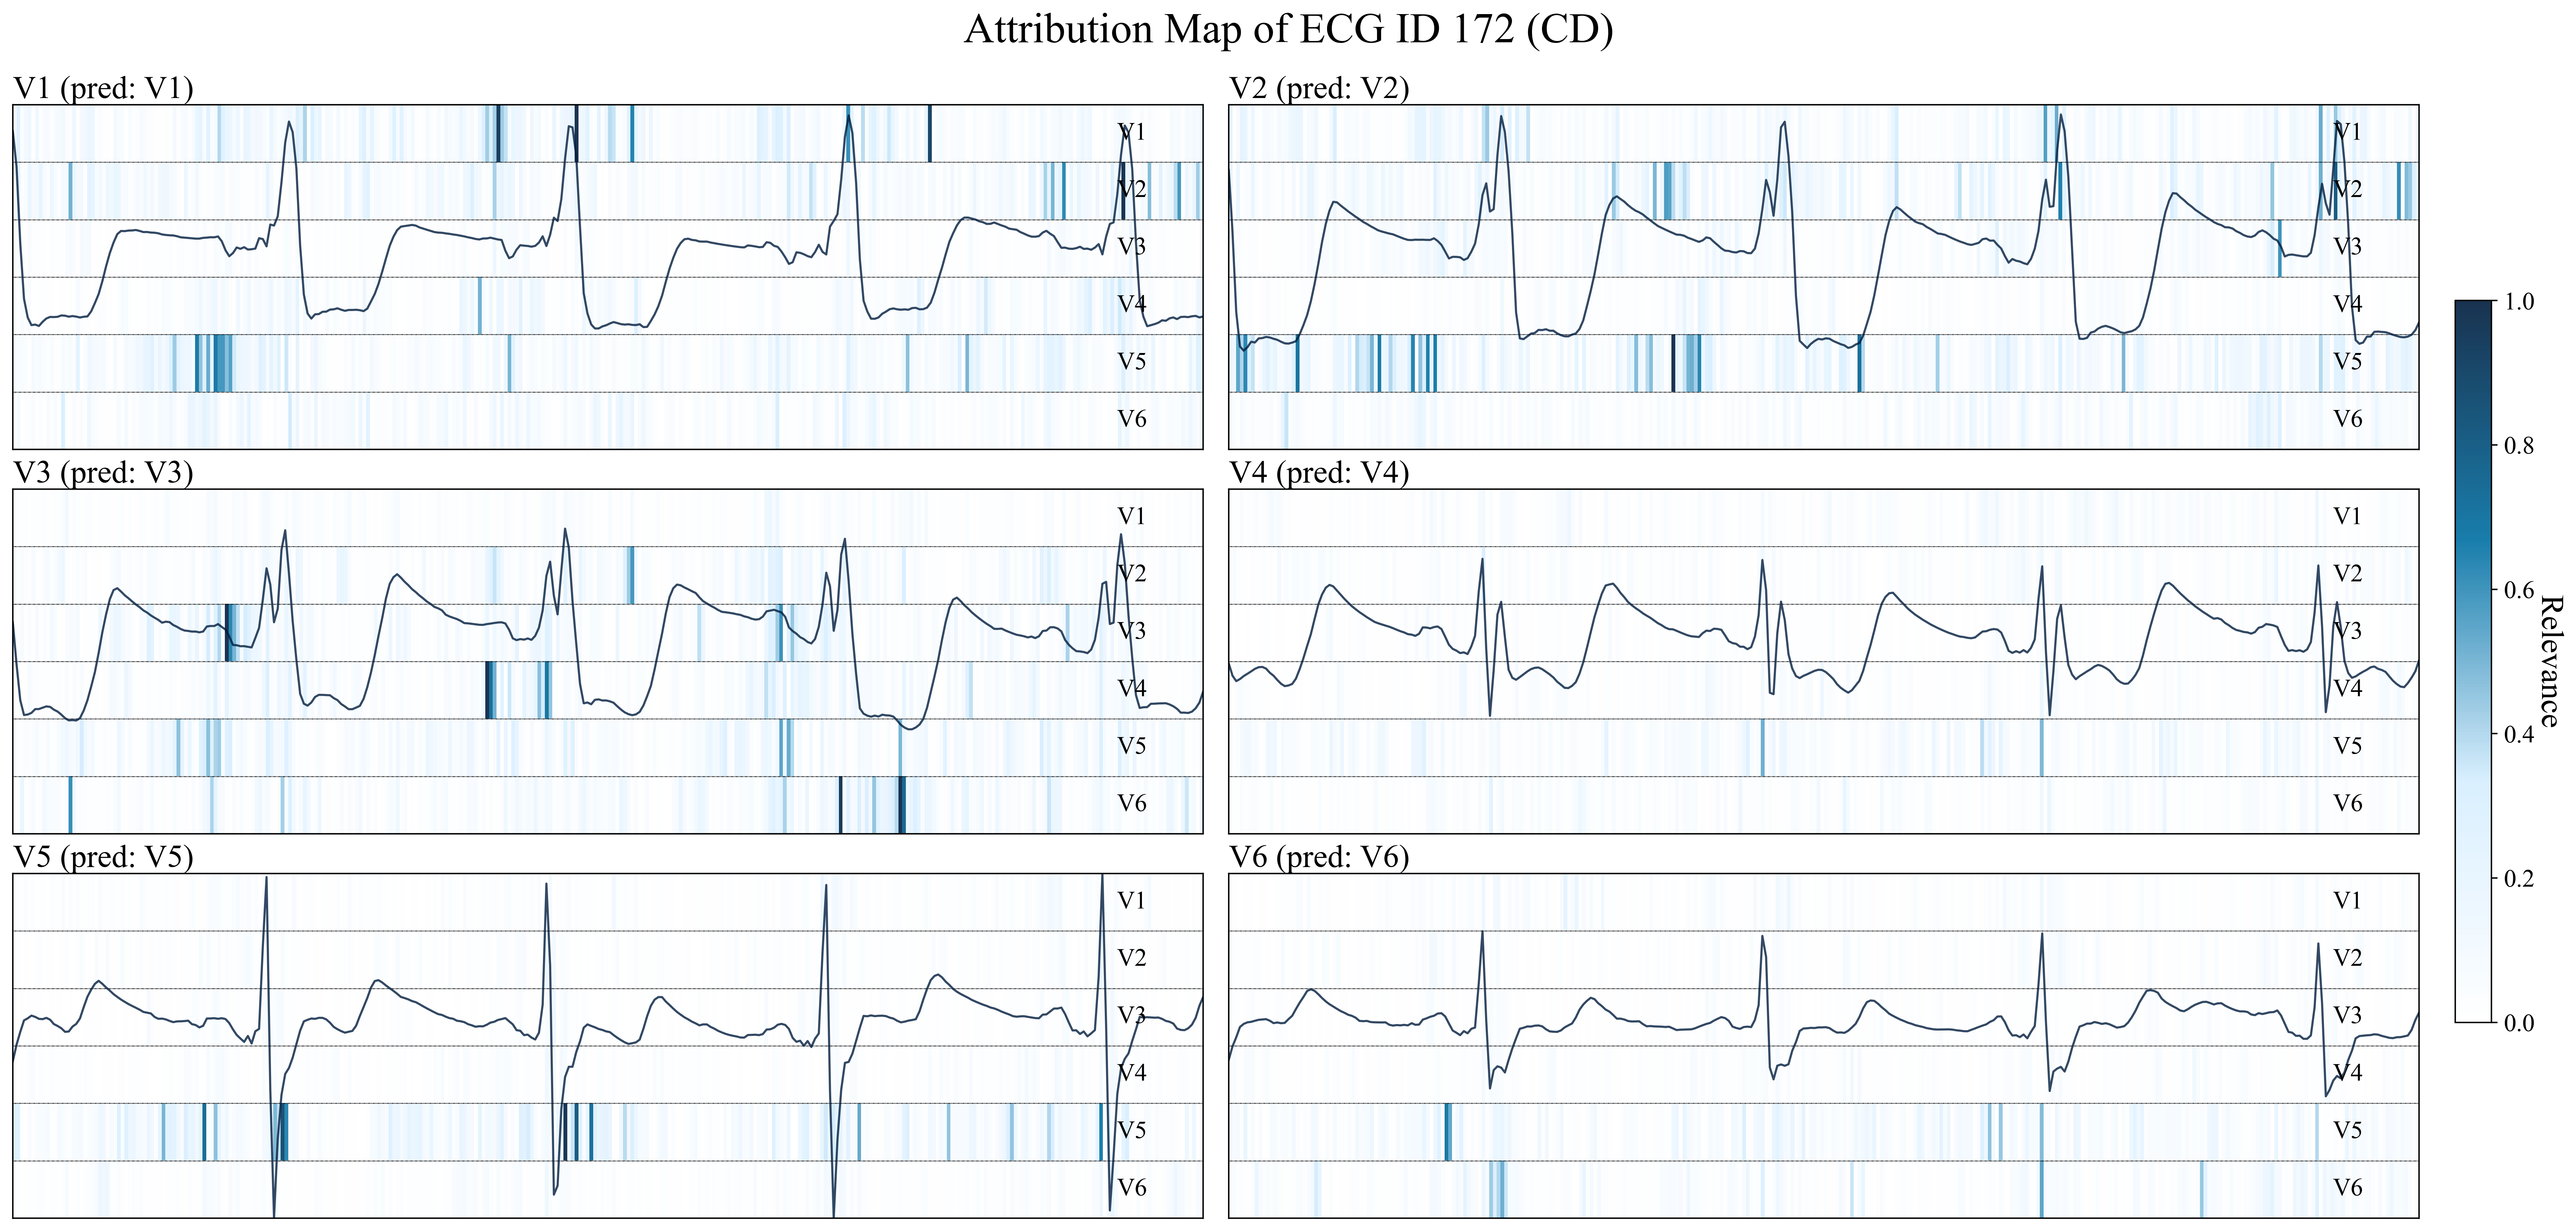

(<Figure size 8000x3600 with 7 Axes>,
 array([<Axes: title={'left': 'V1 (pred: V1)'}>,
        <Axes: title={'left': 'V2 (pred: V2)'}>,
        <Axes: title={'left': 'V3 (pred: V3)'}>,
        <Axes: title={'left': 'V4 (pred: V4)'}>,
        <Axes: title={'left': 'V5 (pred: V5)'}>,
        <Axes: title={'left': 'V6 (pred: V6)'}>], dtype=object))

In [219]:
window_start = best_start + 20
window_end = window_start + window_size + 20

#window_start, window_end = 0, 1000

plot_attribution_map(
    attrs.abs(),
    ecg.squeeze(0),
    title=f"Attribution Map of ECG ID {ecg_id} (CD)",
    time_window=(window_start, window_end),
    lead_names=lead_filter,
    figsize=(10, 3),
    show_hist=False,
    line_alpha=0.8,
    cmap="UM",
    predictions=preds[0],  # Pass the predictions to the plot
    linestyle='-'
)

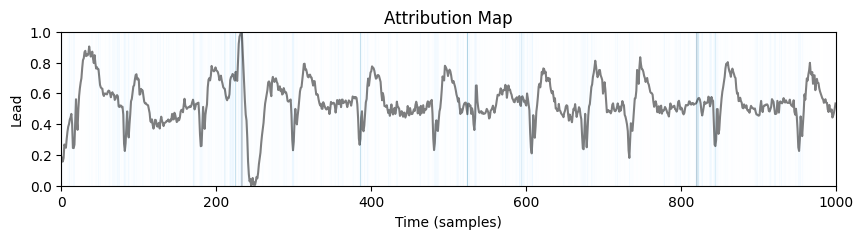

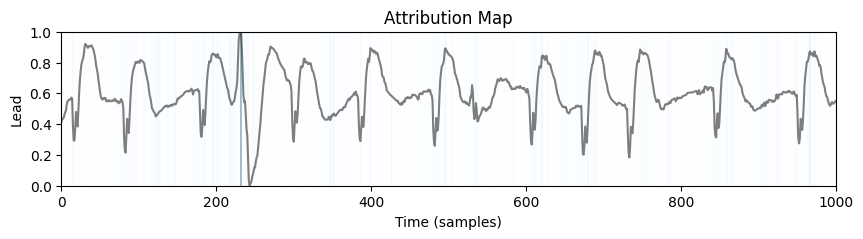

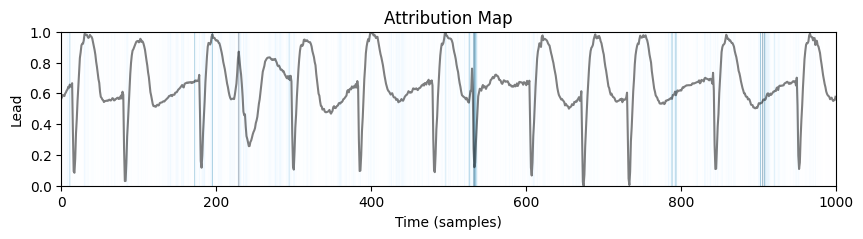

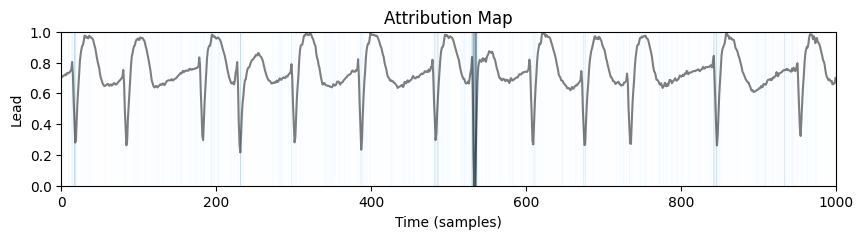

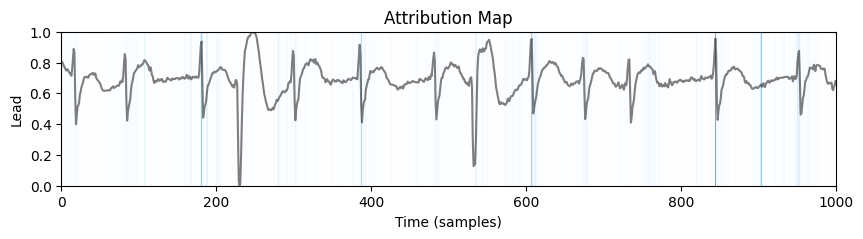

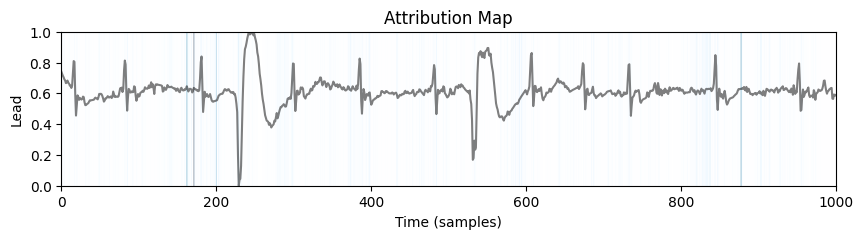

In [57]:
# plot the attribution map as a heatmap
def plot_single_attribution_map(ecg, attribution, window=None):
    """
    Plot the attribution map as a heatmap.
    """
    if window is not None:
        ecg = ecg[window[0]:window[1]]
        attribution = attribution[window[0]:window[1]]

    # Normalize the attribution map
    attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-9)

    # Normalize the ECG signal
    ecg = (ecg - ecg.min()) / (ecg.max() - ecg.min() + 1e-9)

    dark_blue = "#001C3D"
    um_cmap = LinearSegmentedColormap.from_list(
        "um_blues", ["#ffffff", "#d6eeff", "#0070A3", dark_blue], N=256
    )

    fig, ax = plt.subplots(figsize=(10, 2))
    ax.plot(ecg, color="black", alpha=0.5)
    #im = ax.imshow(attribution, aspect="auto", cmap="Reds")
    # Plot 1D attribution map as 2D image
    ax.imshow(attribution.unsqueeze(0), aspect="auto", cmap=um_cmap, alpha=0.5, extent=[0, len(ecg), 0, 1])
    ax.set_title("Attribution Map")
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Lead")
    #fig.colorbar(im, ax=ax)
    plt.show()


for lead in range(6):
    plot_single_attribution_map(ecg.squeeze(0)[lead].cpu().numpy(), attr.squeeze(0).abs().cpu()[lead], window=(0, 1000))